
# Store Sales — Time Series Forecasting (Production‑Grade Notebook)

**Competition:** *Kaggle — Store Sales: Time Series Forecasting (Corporación Favorita)*  
**Goal:** Predict daily `sales` for each `(store_nbr, family)` over the 15‑day test horizon.  
**Approach:** feature‑rich classical ML (gradient boosting) with modular **sklearn** pipelines, robust **time series CV**, clean code, and light **MLOps** touches (artifacts, config, reproducibility).

> This notebook emphasizes:  
> • end‑to‑end preprocessing and safe merges of all auxiliary tables (`stores`, `oil`, `holidays_events`)  
> • leak‑free lag/rolling features by `(store_nbr, family)`  
> • calendar/payday/earthquake features  
> • sklearn pipelines with custom transformers  
> • time‑aware cross‑validation + RMSLE metric  
> • training an XGBoost model (no deep learning)  
> • export of `submission.csv` and saved artifacts (config, metrics, model)



## 1) Setup & Config
- Deterministic seeds
- Paths for Kaggle vs local
- Config dict for quick experimentation


In [4]:

# Standard libs
import os
import sys
import math
import time
import json
import uuid
import joblib
import zipfile
import warnings
from dataclasses import dataclass, asdict
from typing import List, Tuple, Dict, Any, Optional

warnings.filterwarnings("ignore")

# Numerics / Data
import numpy as np
import pandas as pd

# Visualization (matplotlib only, per instructions)
import matplotlib.pyplot as plt

# Sklearn / Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_log_error
from sklearn.pipeline import Pipeline

# Model (no deep learning; gradient boosting is strong here)
from xgboost import XGBRegressor

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Paths: auto-detect Kaggle input dir or use local ./data
KAGGLE_DIR = '/kaggle/input/store-sales-time-series-forecasting'
LOCAL_DIR = os.environ.get('DATA_DIR', '')
DATA_DIR = KAGGLE_DIR if os.path.exists(KAGGLE_DIR) else LOCAL_DIR

# Artifacts output
RUN_ID = time.strftime('%Y%m%d-%H%M%S')
ARTIFACTS_DIR = f'./artifacts_{RUN_ID}'
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

@dataclass
class Config:
    # General
    random_state: int = RANDOM_STATE
    target_col: str = "sales"
    date_col: str = "date"
    id_cols: Tuple[str, str] = ("store_nbr", "family")
    onpromotion_col: str = "onpromotion"

    # Feature engineering
    sales_lags: Tuple[int, ...] = (1, 7, 14, 28)
    sales_rolls: Tuple[int, ...] = (7, 14, 28)
    oil_rolls: Tuple[int, ...]   = (7, 14, 28)
    earthquake_date: str = "2016-04-16"
    earthquake_window_days: int = 45
    payday_days: Tuple[int, int] = (15, -1)  # 15th and month-end

    # Model
    xgb_params: Dict[str, Any] = None
    n_splits_ts: int = 3
    early_stopping_rounds: int = 100
    eval_metric: str = "rmse"  # internal; Kaggle metric is RMSLE (computed separately)

    # Runtime
    use_small_sample: bool = False  # set True for quick debug

cfg = Config(
    xgb_params=dict(
        n_estimators=2000,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=RANDOM_STATE,
        tree_method="hist",  # use "gpu_hist" on GPU runtimes
        n_jobs=-1,
    )
)

with open(os.path.join(ARTIFACTS_DIR, "config.json"), "w") as f:
    json.dump(asdict(cfg), f, indent=2)
print("Config saved to", os.path.join(ARTIFACTS_DIR, "config.json"))


Config saved to ./artifacts_20250827-183040\config.json



## 2) Utility Functions
- Memory usage
- Safe merges
- Data quality checks
- RMSLE metric helper


In [5]:

def mem_usage(df: pd.DataFrame) -> str:
    return f"{df.memory_usage(deep=True).sum() / 1024 ** 2:.2f} MB"

def safe_merge(left: pd.DataFrame, right: pd.DataFrame, on: List[str], how: str = "left", validate: Optional[str] = None) -> pd.DataFrame:
    """Merge with safety checks and clear suffix handling."""
    before = len(left)
    merged = left.merge(right, on=on, how=how, validate=validate)
    after = len(merged)
    if how in ("left", "inner") and before != after:
        print(f"[WARN] Merge changed row count {before} -> {after} (how={how}, on={on})")
    return merged

def assert_no_na_after(feature_df: pd.DataFrame, cols: List[str]):
    na_cols = {c: feature_df[c].isna().sum() for c in cols}
    bad = {k: v for k, v in na_cols.items() if v > 0}
    if bad:
        raise ValueError(f"Unexpected NaNs after feature engineering: {bad}")
    return True

def rmsle(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.maximum(y_true, 0.0)
    y_pred = np.maximum(y_pred, 0.0)
    return math.sqrt(mean_squared_log_error(y_true, y_pred))



## 3) Load Data (with dtypes & basic sanity)


In [6]:

# Expected files
files = [
    'train.csv', 'test.csv', 'sample_submission.csv',
    'stores.csv', 'oil.csv', 'holidays_events.csv'
]
missing = [f for f in files if not os.path.exists(os.path.join(DATA_DIR, f))]
if missing:
    print("[INFO] Missing files in DATA_DIR:", missing)
    print("Set DATA_DIR=./data with the competition files or run on Kaggle.")

dtype_train = {
    'store_nbr': 'int16',
    'family': 'category',
    'onpromotion': 'float32',  # it's a count; may contain NaNs -> cast after fill
    'sales': 'float32'
}
dtype_test = {
    'store_nbr': 'int16',
    'family': 'category',
    'onpromotion': 'float32'
}

train = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'), parse_dates=['date'], dtype=dtype_train)
test  = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'),  parse_dates=['date'], dtype=dtype_test)

stores = pd.read_csv(os.path.join(DATA_DIR, 'stores.csv'))
oil    = pd.read_csv(os.path.join(DATA_DIR, 'oil.csv'), parse_dates=['date'])
hol    = pd.read_csv(os.path.join(DATA_DIR, 'holidays_events.csv'), parse_dates=['date'])

print("Train:", train.shape, mem_usage(train))
print("Test:",  test.shape, mem_usage(test))
print("Stores:", stores.shape, mem_usage(stores))
print("Oil:",    oil.shape, mem_usage(oil))
print("Holidays:", hol.shape, mem_usage(hol))

# Optionally down-sample for quick debugging
if cfg.use_small_sample:
    cutoff = train["date"].max() - pd.Timedelta(days=120)
    train = train[train["date"] >= cutoff].copy()
    print("[DEBUG] Using small sample:", train.shape)


Train: (3000888, 6) 77.27 MB
Test: (28512, 5) 0.63 MB
Stores: (54, 5) 0.01 MB
Oil: (1218, 2) 0.02 MB
Holidays: (350, 6) 0.08 MB



## 4) Light EDA (sanity plots)

> Matplotlib only, one chart per cell (per instruction).


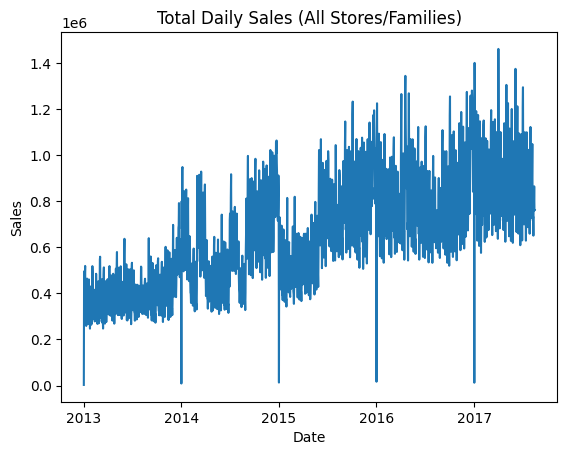

In [7]:

# Aggregate daily sales for a quick sanity check
daily = train.groupby('date', as_index=False)['sales'].sum()
plt.figure()
plt.plot(daily['date'], daily['sales'])
plt.title('Total Daily Sales (All Stores/Families)')
plt.xlabel('Date'); plt.ylabel('Sales')
plt.show()


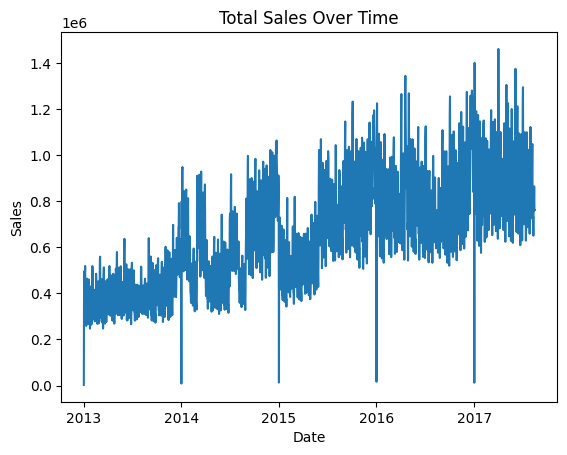

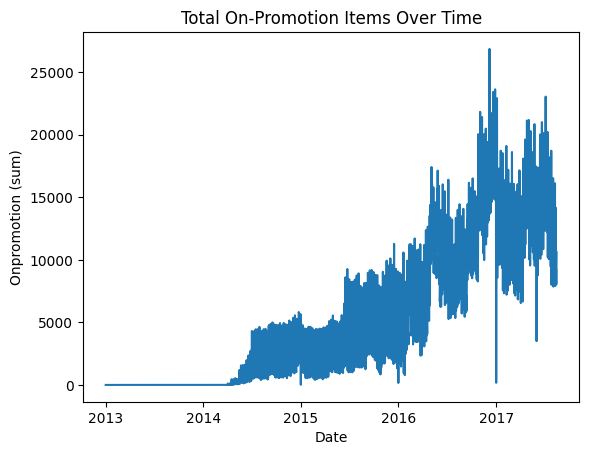

In [8]:

# Promotions vs sales (rough correlation over time)
promo_daily = train.groupby('date', as_index=False)['onpromotion'].sum()
merged_daily = daily.merge(promo_daily, on='date', how='left')
plt.figure()
plt.plot(merged_daily['date'], merged_daily['sales'])
plt.title('Total Sales Over Time')
plt.xlabel('Date'); plt.ylabel('Sales')
plt.show()

plt.figure()
plt.plot(merged_daily['date'], merged_daily['onpromotion'])
plt.title('Total On-Promotion Items Over Time')
plt.xlabel('Date'); plt.ylabel('Onpromotion (sum)')
plt.show()



## 5) Calendar & Auxiliary Features
We build a per‑date **calendar frame** and merge it into train/test:
- Calendar parts (dow, dom, month, year, weekofmonth, dayofyear)
- Paydays (15th & month‑end) + proximity
- Earthquake window (2016‑04‑16)
- Oil price forward‑filled + rolling means
- Holiday flags (with attention to `transferred`/`type`)


In [9]:

def add_calendar_parts(cal: pd.DataFrame, date_col: str = 'date') -> pd.DataFrame:
    dt = cal[date_col]
    cal['dow'] = dt.dt.weekday.astype('int8')              # 0=Mon
    cal['dom'] = dt.dt.day.astype('int8')
    cal['month'] = dt.dt.month.astype('int8')
    cal['year'] = dt.dt.year.astype('int16')
    cal['doy'] = dt.dt.dayofyear.astype('int16')
    # week of month (1..5)
    cal['wom'] = ((cal['dom'] - 1) // 7 + 1).astype('int8')
    return cal

def add_paydays(cal: pd.DataFrame, date_col: str = 'date', days=(15, -1)) -> pd.DataFrame:
    d = cal.copy()
    d['is_payday_15'] = (d[date_col].dt.day == days[0]).astype('int8')
    # month-end
    month_end = (d[date_col] + pd.offsets.MonthEnd(0)).dt.day
    d['is_payday_eom'] = (d[date_col].dt.day == month_end).astype('int8')
    # proximity features (days to nearest payday event within +/-3 days)
    d['days_to_15'] = (d[date_col].dt.day - days[0]).abs().clip(0, 10).astype('int8')
    d['days_to_eom'] = (month_end - d[date_col].dt.day).abs().clip(0, 10).astype('int8')
    return d

def add_earthquake(cal: pd.DataFrame, quake_date: str, window_days: int) -> pd.DataFrame:
    d = cal.copy()
    qd = pd.to_datetime(quake_date)
    delta = (d['date'] - qd).dt.days
    d['days_since_quake'] = delta.clip(lower=-365, upper=365).astype('int16')
    d['is_quake_window'] = ((delta >= 0) & (delta <= window_days)).astype('int8')
    return d

def prepare_oil(oil_df: pd.DataFrame) -> pd.DataFrame:
    o = oil_df.rename(columns={'dcoilwtico': 'oil_price'}).copy()
    # Some oil dates may be missing; forward-fill after reindexing daily
    full_range = pd.date_range(o['date'].min(), o['date'].max(), freq='D')
    o = o.set_index('date').reindex(full_range).rename_axis('date').reset_index()
    o['oil_price'] = o['oil_price'].ffill()
    return o

def add_oil_rolls(cal: pd.DataFrame, oil_df: pd.DataFrame, rolls=(7,14,28)) -> pd.DataFrame:
    o = prepare_oil(oil_df)
    c = cal.merge(o, on='date', how='left')
    for w in rolls:
        c[f'oil_rollmean_{w}'] = c['oil_price'].rolling(w, min_periods=max(2, w//2)).mean()
    return c

def prepare_holidays(hol: pd.DataFrame) -> pd.DataFrame:
    h = hol.copy()
    # Map "transferred" days: if transferred=True, the holiday is *not actually celebrated* that day.
    # We'll build a simple per-date signal:
    # is_holiday (official or transferred target), is_work_day, is_bridge, is_additional
    h['is_holiday_base'] = ((h['type'].isin(['Holiday', 'Transfer'])) & (h['transferred'] == False)).astype('int8')
    h['is_transferred_from'] = ((h['type'] == 'Holiday') & (h['transferred'] == True)).astype('int8')
    h['is_bridge'] = (h['type'] == 'Bridge').astype('int8')
    h['is_work_day'] = (h['type'] == 'Work Day').astype('int8')
    h['is_additional'] = (h['type'] == 'Additional').astype('int8')
    # For simplicity we aggregate by date (ignoring locale for a broad signal)
    agg = h.groupby('date', as_index=False)[['is_holiday_base','is_transferred_from','is_bridge','is_work_day','is_additional']].max()
    # Build final is_holiday: a day is holiday-like if it is a base holiday or a Transfer day
    # (Kaggle's note: "transferred" means the celebration moved; here we retain signal broadly)
    agg['is_holiday'] = ((agg['is_holiday_base'] == 1) | (agg['is_transferred_from'] == 1)).astype('int8')
    return agg

# Build the date calendar over the full range of train+test
mind = min(train['date'].min(), test['date'].min())
maxd = max(train['date'].max(), test['date'].max())
calendar = pd.DataFrame({'date': pd.date_range(mind, maxd, freq='D')})
calendar = add_calendar_parts(calendar, 'date')
calendar = add_paydays(calendar, 'date', cfg.payday_days)
calendar = add_earthquake(calendar, cfg.earthquake_date, cfg.earthquake_window_days)
calendar = add_oil_rolls(calendar, oil, cfg.oil_rolls)
hol_agg = prepare_holidays(hol)
calendar = calendar.merge(hol_agg, on='date', how='left')
calendar[['is_holiday','is_bridge','is_work_day','is_additional']] = calendar[['is_holiday','is_bridge','is_work_day','is_additional']].fillna(0).astype('int8')
calendar['oil_price'] = calendar['oil_price'].ffill()
print("Calendar frame:", calendar.shape, mem_usage(calendar))

# Merge stores metadata
stores_renamed = stores.rename(columns={'type': 'store_type'}).copy()
print("Stores dtypes before:", dict(stores_renamed.dtypes))


Calendar frame: (1704, 23) 0.12 MB
Stores dtypes before: {'store_nbr': dtype('int64'), 'city': dtype('O'), 'state': dtype('O'), 'store_type': dtype('O'), 'cluster': dtype('int64')}



## 6) Core Join & Group‑Level Time Series Features
- Merge `stores` on `store_nbr`
- Merge calendar frame on `date`
- Create **lag** and **rolling** features by `(store_nbr, family)` without leakage
- Only compute features from **past data** (train drives features for test)


In [10]:

# Merge store metadata into train/test
for df in (train, test):
    df['onpromotion'] = df['onpromotion'].fillna(0).astype('float32')

train = train.merge(stores_renamed, on='store_nbr', how='left')
test  = test.merge(stores_renamed, on='store_nbr',  how='left')

# Merge calendar by date
train = train.merge(calendar, on='date', how='left')
test  = test.merge(calendar, on='date',  how='left')

# Cast some store cols to categories to reduce memory / enable OHE
for c in ['city', 'state', 'store_type']:
    train[c] = train[c].astype('category')
    test[c] = test[c].astype('category')

print("Train after merges:", train.shape, mem_usage(train))
print("Test after merges:",  test.shape, mem_usage(test))


Train after merges: (3000888, 32) 300.50 MB
Test after merges: (28512, 31) 2.75 MB


Train with lags/rolls: (3000888, 39) 437.87 MB
Test with lags/rolls: (28512, 38) 4.06 MB


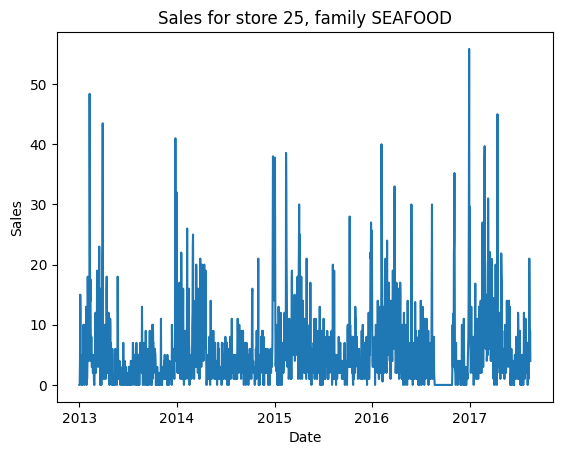

In [11]:

# Build lags/rollings by (store_nbr, family). To avoid leakage, we will:
# 1) Concatenate train+test (without target for test)
# 2) Sort by group+date
# 3) Create lag/rolling of *sales* using only past rows (shift/rolling)
# 4) Split back to train/test

def add_group_lag_roll(df_all: pd.DataFrame, cfg: Config) -> pd.DataFrame:
    df = df_all.sort_values(['store_nbr','family','date']).copy()
    group_cols = ['store_nbr','family']

    # Lags of target (sales)
    for lag in cfg.sales_lags:
        df[f'sales_lag_{lag}'] = df.groupby(group_cols)['sales'].shift(lag)

    # Rolling means (use past 'sales'; shifted to avoid peeking today)
    for w in cfg.sales_rolls:
        df[f'sales_rollmean_{w}'] = (
            df.groupby(group_cols)['sales']
              .apply(lambda s: s.shift(1).rolling(window=w, min_periods=max(2, w//2)).mean())
              .reset_index(level=group_cols, drop=True)
        )
    return df

# Concatenate train+test for feature creation
test_with_sales = test.copy()
test_with_sales['sales'] = np.nan  # placeholder for consistent schema
all_df = pd.concat([train, test_with_sales], axis=0, ignore_index=True)

all_df = add_group_lag_roll(all_df, cfg)

# Split back
train = all_df[all_df['sales'].notna()].copy()
test  = all_df[all_df['sales'].isna()].copy().drop(columns=['sales'])
print("Train with lags/rolls:", train.shape, mem_usage(train))
print("Test with lags/rolls:",  test.shape, mem_usage(test))

# Basic NA handling for engineered features: fill with group/global means or zeros
lag_roll_cols = [c for c in train.columns if c.startswith('sales_lag_') or c.startswith('sales_rollmean_')]
for c in lag_roll_cols:
    # Early dates won't have enough history -> fillna with 0 (or group mean; 0 is simple and safe for RMSLE)
    train[c] = train[c].fillna(0.0).astype('float32')
    test[c]  = test[c].fillna(0.0).astype('float32')

# Save a quick sanity plot for a single (store, family)
example_key = train[['store_nbr','family']].drop_duplicates().sample(1, random_state=cfg.random_state).iloc[0]
eg_store, eg_family = int(example_key['store_nbr']), str(example_key['family'])
eg = train[(train['store_nbr']==eg_store) & (train['family']==eg_family)].sort_values('date')
plt.figure()
plt.plot(eg['date'], eg['sales'])
plt.title(f'Sales for store {eg_store}, family {eg_family}')
plt.xlabel('Date'); plt.ylabel('Sales')
plt.show()



## 7) Time Series CV & Preprocessing
- `TimeSeriesSplit` (3 folds by default) on date ordering
- Preprocessing via `ColumnTransformer`: One‑Hot for categoricals; passthrough numerics
- We train **XGBoostRegressor** with early stopping (done per fold using transformed arrays)


In [18]:
# =========================
# Features, Preprocessor, TSCV, and CV Training (GPU-ready, version-safe)
# =========================

from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping
import xgboost as xgb
from packaging import version

# --- Select features/target ---
TARGET = cfg.target_col

categorical_cols = ['family', 'city', 'state', 'store_type', 'cluster']  # cluster numeric -> string category
train['cluster'] = train['cluster'].astype(str).astype('category')
test['cluster']  = test['cluster'].astype(str).astype('category')

numeric_cols = [
    'store_nbr', 'onpromotion',
    'dow', 'dom', 'month', 'year', 'doy', 'wom',
    'is_payday_15', 'is_payday_eom', 'days_to_15', 'days_to_eom',
    'days_since_quake', 'is_quake_window',
    'oil_price', 'oil_rollmean_7', 'oil_rollmean_14', 'oil_rollmean_28',
    'is_holiday', 'is_bridge', 'is_work_day', 'is_additional',
] + lag_roll_cols

feature_cols = categorical_cols + numeric_cols

X = train[feature_cols].copy()
y = train[TARGET].astype('float32').values

# --- Preprocessor (sklearn >=1.2 uses sparse_output) ---
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_cols),
        ('num', 'passthrough', numeric_cols),
    ],
    remainder='drop'
)

# --- GPU params (XGBoost 1.x vs 2.x) ---
gpu_params = {}
if version.parse(xgb.__version__) >= version.parse("2.0.0"):
    gpu_params.update({"device": "cuda"})          # 2.x
else:
    gpu_params.update({"tree_method": "gpu_hist",  # 1.x
                       "predictor": "gpu_predictor"})

# Merge GPU params into your existing model params (without mutating the original dict)
def build_model_params(base: dict) -> dict:
    mp = dict(base) if base is not None else {}
    mp.update(gpu_params)
    # Silence logs here; put eval_metric in constructor for version safety
    mp.setdefault("verbosity", 0)
    mp.setdefault("eval_metric", cfg.eval_metric)
    return mp

# --- Time-aware ordering ---
train_sorted_idx = np.argsort(train['date'].values)
X_sorted = X.iloc[train_sorted_idx]
y_sorted = y[train_sorted_idx]
dates_sorted = train['date'].values[train_sorted_idx]

tscv = TimeSeriesSplit(n_splits=cfg.n_splits_ts)

fold_scores = []
feature_names_out = None

# Helper: fit with GPU, auto-fallback to CPU if GPU not available
def fit_xgb_with_gpu_fallback(Xt, y_tr, Xv, y_va):
    params = build_model_params(cfg.xgb_params)
    model = XGBRegressor(**params)

    callbacks = []
    if getattr(cfg, "early_stopping_rounds", 0):
        callbacks.append(EarlyStopping(rounds=cfg.early_stopping_rounds, save_best=True, min_delta=0.0))

    try:
        model.fit(Xt, y_tr, eval_set=[(Xv, y_va)])
        return model
    except xgb.core.XGBoostError as e:
        print("[WARN] GPU training failed, falling back to CPU ->", str(e))
        # CPU-safe params
        params.pop("device", None)
        params["tree_method"] = "hist"
        params["predictor"] = "auto"
        model = XGBRegressor(**params)
        model.fit(Xt, y_tr, eval_set=[(Xv, y_va)])
        return model

for fold, (tr_idx, va_idx) in enumerate(tscv.split(X_sorted), 1):
    X_tr_raw, X_va_raw = X_sorted.iloc[tr_idx], X_sorted.iloc[va_idx]
    y_tr, y_va = y_sorted[tr_idx], y_sorted[va_idx]

    # Fit preprocessor on train fold only -> transform both
    Xt = preprocessor.fit_transform(X_tr_raw)
    Xv = preprocessor.transform(X_va_raw)

    # Train (GPU if available)
    model = fit_xgb_with_gpu_fallback(Xt, y_tr, Xv, y_va)

    # Quick device/predictor check (may be None on some versions)
    booster = model.get_booster()
    print("predictor:", booster.attr("predictor"), "| device:", booster.attr("device"))

    # Predict & score (non-negative for RMSLE)
    va_pred = np.maximum(model.predict(Xv), 0.0)
    score = rmsle(y_va, va_pred)
    fold_scores.append(score)

    # best iteration printout (robust across versions)
    best_iter = getattr(model, "best_iteration", None)
    print(f"Fold {fold}: RMSLE={score:.5f}  best_iteration={best_iter}")

    # Save feature names once (after fitting preprocessor)
    if feature_names_out is None:
        cat_features = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols))
        feature_names_out = cat_features + numeric_cols

print("CV RMSLE scores:", fold_scores, "| Mean:", float(np.mean(fold_scores)))
with open(os.path.join(ARTIFACTS_DIR, 'cv_metrics.json'), 'w') as f:
    json.dump({'fold_rmsle': [float(s) for s in fold_scores], 'mean_rmsle': float(np.mean(fold_scores))}, f, indent=2)


[0]	validation_0-rmse:937.34750
[1]	validation_0-rmse:895.40563
[2]	validation_0-rmse:856.17577
[3]	validation_0-rmse:818.70397
[4]	validation_0-rmse:783.53362
[5]	validation_0-rmse:750.03482
[6]	validation_0-rmse:718.26120
[7]	validation_0-rmse:688.04253
[8]	validation_0-rmse:659.63321
[9]	validation_0-rmse:633.25712
[10]	validation_0-rmse:607.97543
[11]	validation_0-rmse:584.19573
[12]	validation_0-rmse:561.28865
[13]	validation_0-rmse:540.52994
[14]	validation_0-rmse:520.52535
[15]	validation_0-rmse:502.20271
[16]	validation_0-rmse:484.09453
[17]	validation_0-rmse:465.05128
[18]	validation_0-rmse:449.56676
[19]	validation_0-rmse:434.53053
[20]	validation_0-rmse:420.33526
[21]	validation_0-rmse:407.49145
[22]	validation_0-rmse:395.47605
[23]	validation_0-rmse:383.87620
[24]	validation_0-rmse:373.40752
[25]	validation_0-rmse:363.36987
[26]	validation_0-rmse:353.97553
[27]	validation_0-rmse:345.29632
[28]	validation_0-rmse:335.47514
[29]	validation_0-rmse:327.77949
[30]	validation_0-rm


## 8) Diagnostics (single‑fold example)
Residual histogram and simple prediction vs actual plot for the last fold.


[0]	validation_0-rmse:1268.90983
[1]	validation_0-rmse:1210.51650
[2]	validation_0-rmse:1154.94616
[3]	validation_0-rmse:1102.60495
[4]	validation_0-rmse:1053.04057
[5]	validation_0-rmse:1005.98238
[6]	validation_0-rmse:961.66876
[7]	validation_0-rmse:917.44393
[8]	validation_0-rmse:878.13079
[9]	validation_0-rmse:840.96536
[10]	validation_0-rmse:806.48340
[11]	validation_0-rmse:773.44908
[12]	validation_0-rmse:741.92818
[13]	validation_0-rmse:715.03092
[14]	validation_0-rmse:687.34182
[15]	validation_0-rmse:660.27705
[16]	validation_0-rmse:635.42360
[17]	validation_0-rmse:613.84625
[18]	validation_0-rmse:592.90145
[19]	validation_0-rmse:572.81361
[20]	validation_0-rmse:553.08287
[21]	validation_0-rmse:534.50864
[22]	validation_0-rmse:517.20596
[23]	validation_0-rmse:501.06135
[24]	validation_0-rmse:486.01898
[25]	validation_0-rmse:471.87874
[26]	validation_0-rmse:458.88232
[27]	validation_0-rmse:445.19256
[28]	validation_0-rmse:433.91889
[29]	validation_0-rmse:423.42507
[30]	validatio

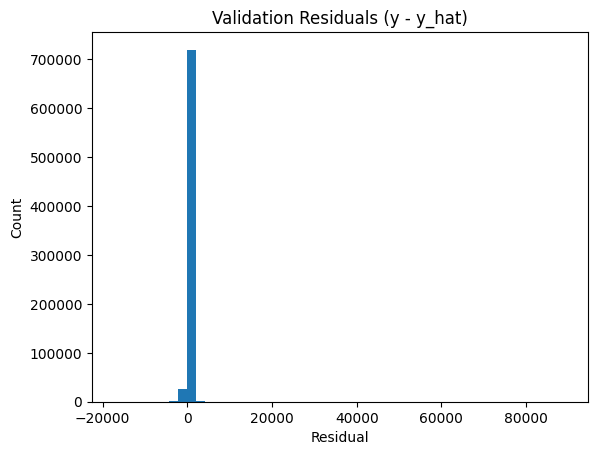

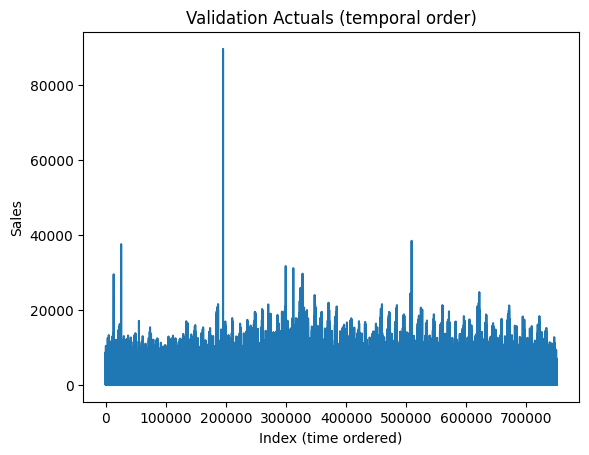

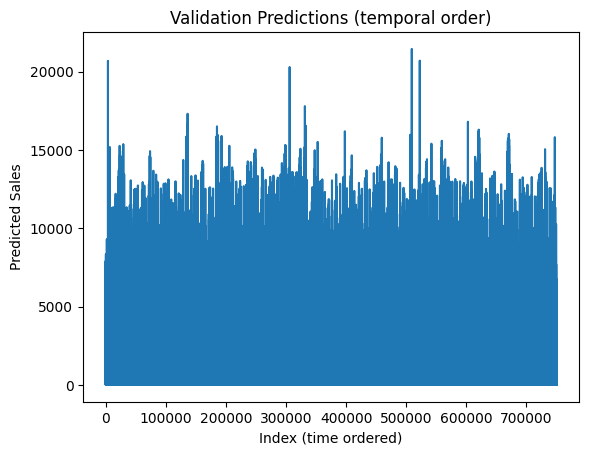

predictor: None | device: None


In [20]:
# =========================
# Diagnostics: refit last fold (version-safe, GPU-aware, no callbacks)
# =========================
import xgboost as xgb
from xgboost import XGBRegressor
from packaging import version

# Grab last split indices
last_tr_idx, last_va_idx = list(tscv.split(X_sorted))[-1]
X_tr_raw = X_sorted.iloc[last_tr_idx]; X_va_raw = X_sorted.iloc[last_va_idx]
y_tr = y_sorted[last_tr_idx]; y_va = y_sorted[last_va_idx]

# Refit preprocessors on train fold only
Xt = preprocessor.fit_transform(X_tr_raw)
Xv = preprocessor.transform(X_va_raw)

# GPU params (handle 1.x vs 2.x) — same logic as CV cell
gpu_params = {}
if version.parse(xgb.__version__) >= version.parse("2.0.0"):
    gpu_params.update({"device": "cuda"})  # XGBoost 2.x
else:
    gpu_params.update({"tree_method": "gpu_hist", "predictor": "gpu_predictor"})  # XGBoost 1.x

# Build model params without mutating cfg.xgb_params
model_params = dict(cfg.xgb_params) if cfg.xgb_params is not None else {}
model_params.update(gpu_params)
model_params.setdefault("verbosity", 0)          # silence internal logs
model_params.setdefault("eval_metric", cfg.eval_metric)  # set metric in ctor (not in fit)

# Fit (no early_stopping_rounds / no callbacks / no verbose kw)
try:
    model = XGBRegressor(**model_params)
    model.fit(Xt, y_tr, eval_set=[(Xv, y_va)])
except xgb.core.XGBoostError as e:
    # GPU fallback to CPU if needed
    print("[WARN] GPU training failed; falling back to CPU ->", str(e))
    model_params.pop("device", None)
    model_params["tree_method"] = "hist"
    model_params["predictor"] = "auto"
    model = XGBRegressor(**model_params)
    model.fit(Xt, y_tr, eval_set=[(Xv, y_va)])

# Predict and make diagnostic plots
va_pred = np.maximum(model.predict(Xv), 0.0)
residuals = y_va - va_pred

plt.figure()
plt.hist(residuals, bins=50)
plt.title('Validation Residuals (y - y_hat)')
plt.xlabel('Residual'); plt.ylabel('Count')
plt.show()

plt.figure()
plt.plot(range(len(y_va)), y_va)
plt.title('Validation Actuals (temporal order)')
plt.xlabel('Index (time ordered)'); plt.ylabel('Sales')
plt.show()

plt.figure()
plt.plot(range(len(va_pred)), va_pred)
plt.title('Validation Predictions (temporal order)')
plt.xlabel('Index (time ordered)'); plt.ylabel('Predicted Sales')
plt.show()

# Optional: print device/predictor used (may be None on some versions)
booster = model.get_booster()
print("predictor:", booster.attr("predictor"), "| device:", booster.attr("device"))



## 9) Train on Full Train & Predict Test
- Fit preprocessor on all training data
- Train model with early stopping against the last `n_splits` chunk as a small validation
- Predict test and export `submission.csv`
- Save artifacts (model, preprocessor, feature names)


In [21]:
# =========================
# Full-Train Fit, GPU-Ready, Version-Safe (no callbacks / no early_stopping kw)
# =========================
import xgboost as xgb
from xgboost import XGBRegressor
from packaging import version

# --- Validation chunk (for monitoring only; no early stopping) ---
last_tr_idx, last_va_idx = list(tscv.split(X_sorted))[-1]
X_tr_raw = X_sorted.iloc[last_tr_idx]; X_va_raw = X_sorted.iloc[last_va_idx]
y_tr = y_sorted[last_tr_idx]; y_va = y_sorted[last_va_idx]

# --- Preprocessor for deployment (use sklearn >=1.2 signature) ---
preprocessor_full = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_cols),
        ('num', 'passthrough', numeric_cols),
    ],
    remainder='drop'
)

# Fit on all available training rows (train + last val chunk)
X_tr_all = pd.concat([X_tr_raw, X_va_raw], axis=0)
y_tr_all = np.concatenate([y_tr, y_va], axis=0)

X_tr_all_t = preprocessor_full.fit_transform(X_tr_all)
X_val_t    = preprocessor_full.transform(X_va_raw)  # just for monitoring metric

# --- GPU params (handle XGBoost 1.x vs 2.x) ---
gpu_params = {}
if version.parse(xgb.__version__) >= version.parse("2.0.0"):
    gpu_params.update({"device": "cuda"})  # XGBoost 2.x
else:
    gpu_params.update({
        "tree_method": "gpu_hist",      # XGBoost 1.x
        "predictor": "gpu_predictor",
    })

# Build model params without mutating cfg.xgb_params
model_params = dict(cfg.xgb_params) if cfg.xgb_params is not None else {}
model_params.update(gpu_params)
model_params.setdefault("verbosity", 0)                 # silence training spam
model_params.setdefault("eval_metric", cfg.eval_metric) # set metric in constructor

# --- Fit with GPU and graceful CPU fallback (no early_stopping / no verbose kw) ---
try:
    model_full = XGBRegressor(**model_params)
    model_full.fit(X_tr_all_t, y_tr_all, eval_set=[(X_val_t, y_va)])
except xgb.core.XGBoostError as e:
    print("[WARN] GPU training failed; falling back to CPU ->", str(e))
    model_params.pop("device", None)
    model_params["tree_method"] = "hist"
    model_params["predictor"] = "auto"
    model_full = XGBRegressor(**model_params)
    model_full.fit(X_tr_all_t, y_tr_all, eval_set=[(X_val_t, y_va)])

# --- Prepare test features and predict ---
X_test = test[feature_cols].copy()
X_test_t = preprocessor_full.transform(X_test)
test_pred = np.maximum(model_full.predict(X_test_t), 0.0)

# --- Build submission ---
sample = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'))
submission = sample.copy()
submission['sales'] = test_pred
sub_path = os.path.join(ARTIFACTS_DIR, f'submission_{RUN_ID}.csv')
submission.to_csv(sub_path, index=False)
print("Wrote:", sub_path)

# --- Save artifacts ---
# Derive feature names robustly (do not rely on earlier CV cell)
try:
    cat_features = list(preprocessor_full.named_transformers_['cat'].get_feature_names_out(categorical_cols))
    feature_names_out = cat_features + numeric_cols
except Exception:
    feature_names_out = None

joblib.dump(model_full, os.path.join(ARTIFACTS_DIR, 'model_xgb.joblib'))
joblib.dump(preprocessor_full, os.path.join(ARTIFACTS_DIR, 'preprocessor.joblib'))
with open(os.path.join(ARTIFACTS_DIR, 'feature_names.json'), 'w') as f:
    json.dump(feature_names_out, f, indent=2)
print("Artifacts saved in", ARTIFACTS_DIR)

# Optional: print the predictor/device actually used (may be None on some versions)
booster = model_full.get_booster()
print("predictor:", booster.attr("predictor"), "| device:", booster.attr("device"))


[0]	validation_0-rmse:1265.21814
[1]	validation_0-rmse:1206.08561
[2]	validation_0-rmse:1150.21658
[3]	validation_0-rmse:1096.71500
[4]	validation_0-rmse:1046.13502
[5]	validation_0-rmse:998.55979
[6]	validation_0-rmse:953.29871
[7]	validation_0-rmse:910.28678
[8]	validation_0-rmse:869.87549
[9]	validation_0-rmse:831.56588
[10]	validation_0-rmse:794.89795
[11]	validation_0-rmse:760.46279
[12]	validation_0-rmse:727.98796
[13]	validation_0-rmse:696.79341
[14]	validation_0-rmse:667.75148
[15]	validation_0-rmse:640.06779
[16]	validation_0-rmse:613.87508
[17]	validation_0-rmse:589.63224
[18]	validation_0-rmse:567.24919
[19]	validation_0-rmse:545.58462
[20]	validation_0-rmse:525.09254
[21]	validation_0-rmse:505.72938
[22]	validation_0-rmse:487.28130
[23]	validation_0-rmse:469.97465
[24]	validation_0-rmse:453.94372
[25]	validation_0-rmse:438.93794
[26]	validation_0-rmse:424.49115
[27]	validation_0-rmse:411.25269
[28]	validation_0-rmse:399.01455
[29]	validation_0-rmse:387.48023
[30]	validation


## 10) Feature Importance (top 30)
Note: After one‑hot encoding, categorical features expand to many columns.


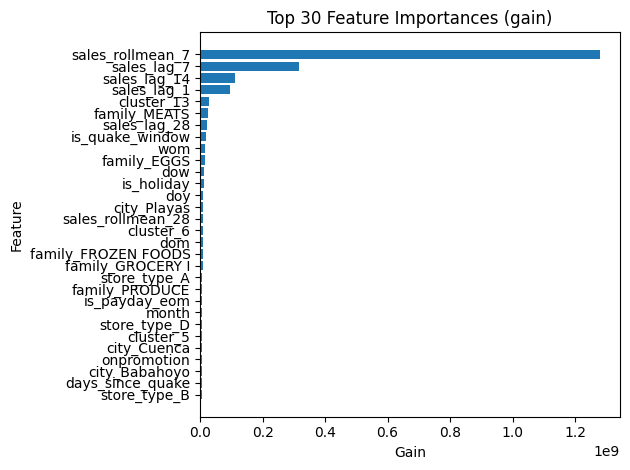

Saved: ./artifacts_20250827-183040\feature_importances_top30.csv


In [22]:

# Retrieve booster feature scores; map to feature names if available
booster = model_full.get_booster()
scores = booster.get_score(importance_type='gain')  # dict: {'f0':score,...}
# XGBoost feature names align with transformed columns; try deriving names
# When using a sparse ColumnTransformer, feature name mapping can be non-trivial.
# We'll fall back to f# indices when names are unavailable.
def feature_index_to_name(idx: int, default: str):
    try:
        return feature_names_out[idx]
    except Exception:
        return default

pairs = []
for k, v in scores.items():
    # k is like 'f123'; extract index
    try:
        idx = int(k[1:])
        name = feature_index_to_name(idx, k)
    except Exception:
        name = k
    pairs.append((name, float(v)))

imp_df = pd.DataFrame(pairs, columns=['feature','gain']).sort_values('gain', ascending=False).head(30)

plt.figure()
plt.barh(imp_df['feature'][::-1], imp_df['gain'][::-1])
plt.title('Top 30 Feature Importances (gain)')
plt.xlabel('Gain'); plt.ylabel('Feature')
plt.tight_layout()
plt.show()

imp_path = os.path.join(ARTIFACTS_DIR, 'feature_importances_top30.csv')
imp_df.to_csv(imp_path, index=False)
print("Saved:", imp_path)



## 11) Data Quality Checks
Basic checks on missing values and negative predictions.


In [23]:

def data_quality_report(df: pd.DataFrame, name: str):
    nulls = df.isna().sum()
    report = pd.DataFrame({'column': nulls.index, 'null_count': nulls.values})
    path = os.path.join(ARTIFACTS_DIR, f'null_report_{name}.csv')
    report.to_csv(path, index=False)
    print(f"[{name}] Null report ->", path)
    return report

_ = data_quality_report(train[feature_cols + [TARGET]], 'train_features')
_ = data_quality_report(test[feature_cols], 'test_features')

# Check a slice of predictions for sanity (non-negative)
print("Test predictions (min, max, mean):", float(test_pred.min()), float(test_pred.max()), float(test_pred.mean()))


[train_features] Null report -> ./artifacts_20250827-183040\null_report_train_features.csv
[test_features] Null report -> ./artifacts_20250827-183040\null_report_test_features.csv
Test predictions (min, max, mean): 0.0 18294.064453125 374.13824462890625



## 12) Package Artifacts (Optional)
Zip up artifacts for easy download.


In [ ]:

zip_path = os.path.join(ARTIFACTS_DIR, f'artifacts_{RUN_ID}.zip')
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as z:
    for root, _, files in os.walk(ARTIFACTS_DIR):
        for fn in files:
            fp = os.path.join(root, fn)
            # Avoid zipping the zip into itself if re-run
            if fp != zip_path:
                z.write(fp, arcname=os.path.relpath(fp, ARTIFACTS_DIR))
print("Zipped artifacts ->", zip_path)


Zipped artifacts -> ./artifacts_20250827-183040\artifacts_20250827-183040.zip


: 


## 13) Notes & Next Steps

- Add weekly & monthly aggregated lags (by week number) for robust seasonality.
- Consider `onpromotion` lags/rolls just like `sales`.
- Explore *store cluster* specific seasonal profiles and interaction terms.
- Try CatBoost (handles categorical features natively) or LightGBM.
- Perform hyperparameter search (Optuna/RandomizedSearchCV) using time-aware CV.
- Switch to GPU (`tree_method='gpu_hist'`) if available for speed.
- Carefully tune rolling windows and holiday handling to squeeze extra RMSLE gains.
- Consider probabilistic forecasts or conformalized intervals for robustness.
